In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5' 
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from sklearn.preprocessing import MinMaxScaler
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Reshape, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError

# for SNGP
import official.nlp.modeling.layers as nlp_layers

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae

plt.rcParams.update({'font.size': 18})

## Load the Capacity data
- Three datasets: Train, Test1, Test2, Test3

In [2]:
number_cells = [41,42,40,45] # train and three tests
dataset = ['train', 'test1', 'test2', 'test3']

all_Q_curves = pd.DataFrame()
for myset in range(len(dataset)):
    for cell in range(number_cells[myset]):
        cell_Q = pd.read_csv("Dataset/discharge_capacity/"+dataset[myset]+"/cell"+str(cell+1)+".csv", 
                               header = None, names=['cycle_no', 'capacity', 'initial_capacity'])
        cell_Q['cell_no'] = cell+1 # cell number
        cell_Q['norm_Q'] = cell_Q['capacity']/cell_Q['initial_capacity'].iloc[0] # cell number
        cell_Q['dataset'] = dataset[myset]
        all_Q_curves = pd.concat([all_Q_curves, cell_Q], axis=0)

## Load the VQ curve data

### We will use VQ(cycle=100)-VQ(cycle=10) as feature to determine RUL

In [3]:
VQcol_names = ["cycle_"+str(i+1) for i in range(150)]
all_VQ_curves = pd.DataFrame()
for myset in range(len(dataset)):
    for cell in range(number_cells[myset]):
        cell_VQ = pd.read_csv("Dataset/V_Q_curve/"+dataset[myset]+"/cell"+str(cell+1)+".csv", header = None,
                               names=VQcol_names)
        cell_VQ['voltage'] = np.linspace(3.5,2,cell_VQ.shape[0])
        cell_VQ['diff_cycle100_cycle10'] = cell_VQ['cycle_100']-cell_VQ['cycle_10']
        cell_VQ['cell_no'] = cell+1 # cell number
        cell_VQ['dataset'] = dataset[myset]
        all_VQ_curves = pd.concat([all_VQ_curves, cell_VQ], axis=0)

In [4]:
all_cycle_lives = pd.DataFrame()
for myset in range(len(dataset)):
    cycle_lives = pd.read_csv("Dataset/cycle_lives/"+dataset[myset]+"_cycle_lives.csv", header = None,
                             names=['cycle_life']).reset_index()
    cycle_lives['cell_no'] = cycle_lives['index'] + 1
    cycle_lives['dataset'] = dataset[myset]
    
    all_cycle_lives = pd.concat([all_cycle_lives, cycle_lives.drop('index', axis=1)], axis=0)

In [5]:
all_VQ_curves_merge = pd.merge(all_VQ_curves, all_cycle_lives, how='left',
                               left_on = ['dataset', 'cell_no'], right_on = ['dataset', 'cell_no'])
all_VQ_curves_merge_agg = all_VQ_curves_merge.groupby(by=['cell_no', 'dataset']).agg({'diff_cycle100_cycle10':'var',
                                                            'cycle_life': 'mean'}).reset_index()

## Make Input-Output for training the UQ models
Input:- VQ(100)-VQ(10)

Output:- cycle life

In [6]:
def get_input_output(df, myset):
    df_myset = df.loc[df['dataset']==myset]
    X, Y = [], []
    for mycell in sorted(set(df_myset['cell_no'])):
        X.append(df_myset.loc[df_myset['cell_no']==mycell].sort_values(
            by='voltage', ascending = False, axis = 0)['diff_cycle100_cycle10'].values)
        Y.append(df_myset.loc[df_myset['cell_no']==mycell]['cycle_life'].mean())
    return X, np.expand_dims(Y, axis=1)

In [7]:
Xtrain, Ytrain = get_input_output(all_VQ_curves_merge, 'train')
Xtest1, Ytest1 = get_input_output(all_VQ_curves_merge, 'test1')
Xtest2, Ytest2 = get_input_output(all_VQ_curves_merge, 'test2')
Xtest3, Ytest3 = get_input_output(all_VQ_curves_merge, 'test3')

scalerX = MinMaxScaler()
Xtrain_norm, Ytrain_norm  = scalerX.fit_transform(Xtrain), (Ytrain)/np.max(Ytrain)
Xtest1_norm, Ytest1_norm  = scalerX.transform(Xtest1), (Ytest1)/np.max(Ytrain)
Xtest2_norm, Ytest2_norm  = scalerX.transform(Xtest2), (Ytest2)/np.max(Ytrain)
Xtest3_norm, Ytest3_norm  = scalerX.transform(Xtest3), (Ytest3)/np.max(Ytrain)

## Common functions definitions

In [8]:
# Get calibration curves
def get_confidence_interval(y_true, mu, sigma):
    alphas = np.linspace(1e-10, 1-1e-10, 1000)
    myCI=[]
    for myalpha in sorted(alphas):
        intervals = scipy.stats.norm.interval(alpha=myalpha, loc=mu, scale=sigma)
        lower_bd = intervals[0]
        upper_bd = intervals[1]
        myCI.append(np.sum((y_true > lower_bd) & (y_true < upper_bd))/len(y_true))
    
    return 100*alphas, 100*np.array(myCI)  # converting to percentages


def get_rmse(y_true, y_pred):
    """
    Inputs:
    y_true - true values
    y_pred - predicted values
    Outputs:
    root mean squarred error
    """
    return np.sqrt(np.mean((y_true-y_pred)**2))

## Uncertainty Model 3: SNGP

distance-aware based

 - spectral normalization from keras layers
 - gaussian process from gpflow, gpflux libraries

(inspiration from https://secondmind-labs.github.io/GPflux/notebooks/gpflux_with_keras_layers.html and https://www.tensorflow.org/tutorials/understanding/sngp)

In [9]:
class FC_SNGP(tf.keras.Model):
    def __init__(self, no_outputs, spec_norm_bound=0.9, actfn = 'relu', **kwargs):
        super().__init__()
        self.actfn = actfn
        self.spec_norm_bound = spec_norm_bound
        self.kwargs = kwargs

        # hidden layers.
        self.dense_layers1 = nlp_layers.SpectralNormalization(self.make_dense_layer(100),
                                                              norm_multiplier=self.spec_norm_bound)
        self.dense_layers2 = nlp_layers.SpectralNormalization(self.make_dense_layer(100),
                                                              norm_multiplier=self.spec_norm_bound)
        self.dense_layers3 = nlp_layers.SpectralNormalization(self.make_dense_layer(10),
                                                              norm_multiplier=self.spec_norm_bound)
        # output layer.
        self.regressor = self.make_output_layer(no_outputs)

    def call(self, inputs, training=True, return_covmat=False):
        x = self.dense_layers1(inputs)
        for _ in range(2):
            x = self.dense_layers2(x)
            x1 = self.dense_layers2(x)
            x = x1 + x
        x = self.dense_layers3(x)
        mean = self.regressor(x)[0]
        variance = self.regressor(x)[1]
        if not training and return_covmat:
            return mean, variance
        
        return mean

    def make_dense_layer(self, hidden_units):
        """Use the Dense layer as the hidden layer."""
        return tf.keras.layers.Dense(hidden_units, activation=self.actfn)

    def make_output_layer(self, no_outputs):
        """Uses Gaussian process as the output layer."""
        return nlp_layers.RandomFeatureGaussianProcess(
            no_outputs,
            gp_cov_momentum=-1,
            **self.kwargs)

class ResetCovarianceCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        """Resets covariance matrix at the beginning of the epoch."""
        if epoch > 0:
            self.model.regressor.reset_covariance_matrix()

class FC_SNGPWithCovReset(FC_SNGP):
    def fit(self, *args, **kwargs):
        """Adds ResetCovarianceCallback to model callbacks."""
        kwargs["callbacks"] = list(kwargs.get("callbacks", []))
        kwargs["callbacks"].append(ResetCovarianceCallback())
        return super().fit(*args, **kwargs)

In [10]:
def generate_trained_SNGPmodel(trainX, trainY, nepochs, actfn = 'sigmoid', spec_norm_bound = 0.8):
    """
    Inputs:
    trainX  - training input of shape (samples, num of features)
    trainY  - training output of shape (samples, 1)
    nepochs - number of epochs
    actfn   - activation function
    spec_norm_bound - spectral normalization bounds
    Outputs:
    model   - trained SNGP model
    """
    loss = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

    model = FC_SNGPWithCovReset(no_outputs=1, spec_norm_bound = spec_norm_bound, actfn=actfn)
    model.compile(loss=loss, optimizer=optimizer)
    model.fit(trainX, trainY, batch_size=10, epochs=nepochs, verbose=0)
    return model

In [ ]:
# parametric study for optimizing 
# EP = [5000, 10000, 20000]
# AC = ['relu']
# MU = [0.8, 0.9, 0.95]

# for myact in AC:
#     for myepoch in EP:
#         for multiplier in MU:
#             print(myact, myepoch, multiplier)
#             model_SNGP = generate_trained_SNGPmodel(Xtrain_norm, Ytrain_norm, myepoch, myact, multiplier)
#             print("Train RMSE: ", get_rmse(model_SNGP(Xtrain_norm, training=False, 
#                                                       return_covmat=True)[0]*(np.max(Ytrain)), Ytrain))
#             print("Test1 RMSE: ", get_rmse(model_SNGP(Xtest1_norm, raining=False,
#                                                       return_covmat=True)[0]*(np.max(Ytrain)), Ytest1))
#             print("Test2 RMSE: ", get_rmse(model_SNGP(Xtest2_norm, raining=False,
#                                                       return_covmat=True)[0]*(np.max(Ytrain)), Ytest2))
#             print("Test3 RMSE: ", get_rmse(model_SNGP(Xtest3_norm, raining=False,
#                                                       return_covmat=True)[0]*(np.max(Ytrain)), Ytest3))

In [13]:
# single run
model_SNGP = generate_trained_SNGPmodel(Xtrain_norm, Ytrain_norm, 10000, 'relu', 0.9)
allresults_SNGPdf = pd.DataFrame()
for myset in dataset:
    exec("Xnorm =X"+myset+"_norm")
    exec("Y =Y"+myset)

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    result_df["SNGP_mu_eff"] = model_SNGP(Xnorm, training=False, return_covmat=True)[0]
    result_df["SNGP_sigma_eff"] = np.sqrt(tf.linalg.diag_part(
                                          model_SNGP(Xnorm, training=False, return_covmat=True)[1])[:, None]
                                         )
    allresults_SNGPdf = pd.concat([allresults_SNGPdf, result_df], axis = 0)

allresults_SNGPdf["SNGP_mu_eff"] = allresults_SNGPdf["SNGP_mu_eff"]*(np.max(Ytrain))
allresults_SNGPdf["SNGP_sigma_eff"] = allresults_SNGPdf["SNGP_sigma_eff"]*(np.max(Ytrain))

print("Train RMSE: ", get_rmse(model_SNGP(Xtrain_norm, training=False, 
                                          return_covmat=True)[0]*(np.max(Ytrain)), Ytrain))
print("Test1 RMSE: ", get_rmse(model_SNGP(Xtest1_norm, training=False,
                                          return_covmat=True)[0]*(np.max(Ytrain)), Ytest1))
print("Test2 RMSE: ", get_rmse(model_SNGP(Xtest2_norm, training=False,
                                          return_covmat=True)[0]*(np.max(Ytrain)), Ytest2))
print("Test3 RMSE: ", get_rmse(model_SNGP(Xtest3_norm, training=False,
                                          return_covmat=True)[0]*(np.max(Ytrain)), Ytest3))

Train RMSE:  62.61664
Test1 RMSE:  116.79648
Test2 RMSE:  198.44405
Test3 RMSE:  273.15652


In [15]:
model_train_bool = False
if model_train_bool:
    nmodels = 3 # total models trained and best one picked
    niter = 10

    allCI_SNGP = np.zeros((1000, niter))
    pbar=ProgressBar()
    allresults_SNGPdf = pd.DataFrame()

    for myiter in pbar(range(niter)): # for each independent iteration
        all_models_SNGP=[]
        all_rmse_train_SNGP = np.zeros(nmodels,)
        for i in range(nmodels): # train multiple models to select the best
            model_SNGP = generate_trained_SNGPmodel(Xtrain_norm, Ytrain_norm, 10000, 'relu', 0.9)
            all_rmse_train_SNGP[i] = get_rmse(model_SNGP(Xtrain_norm, training = False, 
                                                         return_covmat=True)[0]*(np.max(Ytrain)), Ytrain)
            all_models_SNGP.append(model_SNGP)
        select_modelSNGP = all_models_SNGP[np.argmin(all_rmse_train_SNGP)] # best model

             
        for myset in dataset:
            exec("Xnorm =X"+myset+"_norm")
            exec("Y =Y"+myset)

            result_df = pd.DataFrame(Y, columns = ['True'])
            result_df['dataset'] = myset
            result_df["SNGP_mu_eff"] = select_modelSNGP(Xnorm, training=False, return_covmat=True)[0]
            result_df["SNGP_sigma_eff"] = np.sqrt(tf.linalg.diag_part(
                                          select_modelSNGP(Xnorm, training=False, return_covmat=True)[1])[:, None]
                                                 )
            result_df['iteration'] = myiter
            allresults_SNGPdf = pd.concat([allresults_SNGPdf, result_df], axis = 0)
               
    allresults_SNGPdf["SNGP_mu_eff"] = allresults_SNGPdf["SNGP_mu_eff"]*(np.max(Ytrain))
    allresults_SNGPdf["SNGP_sigma_eff"] = allresults_SNGPdf["SNGP_sigma_eff"]*(np.max(Ytrain))
    allresults_SNGPdf.to_excel("SNGP_battery_prediction_results.xlsx")  
else:
    allresults_SNGPdf=pd.read_excel("SNGP_battery_prediction_results.xlsx")  

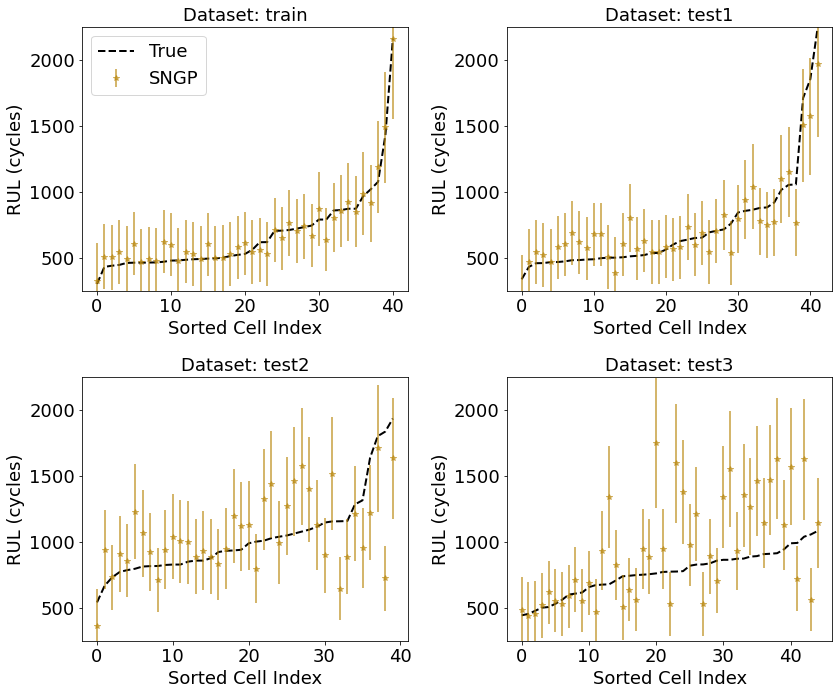

In [16]:
myiter = 3 # pick any one of 10 iterations
allresults_SNGPdf_sorted = allresults_SNGPdf.loc[allresults_SNGPdf['iteration']==myiter].sort_values(by='True', ascending=True)

fig, ax = plt.subplots(2,2,figsize=(12, 10))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    # True
    df = allresults_SNGPdf_sorted.loc[allresults_SNGPdf_sorted['dataset']==dataset[myset]]
    myax.plot(range(df.shape[0]), df['True'], 
             color='black', linestyle='dashed', linewidth=2, label='True')
    # SNGP
    df = allresults_SNGPdf_sorted.loc[allresults_SNGPdf_sorted['dataset']==dataset[myset]]
    myax.errorbar(range(df.shape[0]), df['SNGP_mu_eff'], 
                 yerr = df['SNGP_sigma_eff'],
                 fmt='*', color='darkgoldenrod', alpha = 0.6, elinewidth=2 , label='SNGP')

    
    myax.set_title("Dataset: "+ dataset[myset], fontsize=18)
    myax.set_xlabel("Sorted Cell Index")
    myax.set_ylabel("RUL (cycles)")
    myax.set_ylim([250, 2250])
    if myset ==0:
        myax.legend()
plt.tight_layout()